In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/media/robert/Data_Storage/Data/Experimental/Lithium_Oven/Lithium_Oven_Test/'
lam = 0.796
tau = 30
# All length units are in um

In [2]:
plasma, I, z, sim_start, sim_length, pulse = design.load_plasma_design(path)

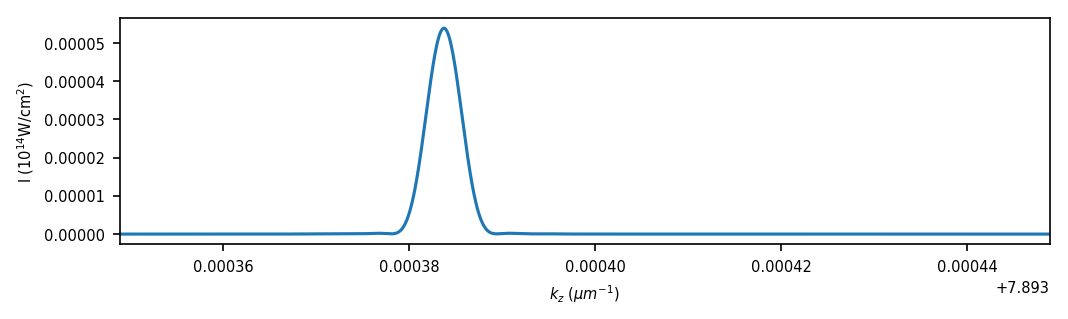

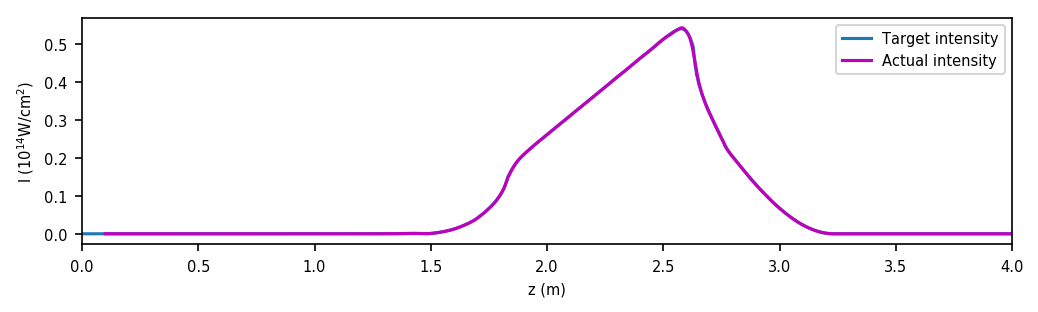

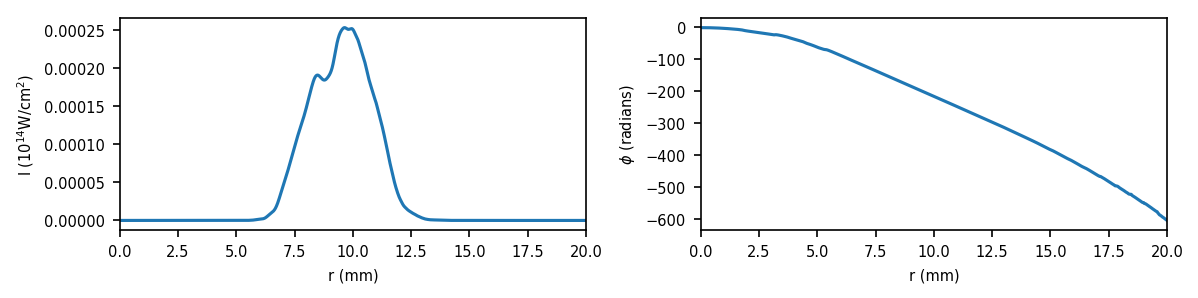

In [3]:
# Optic design upstream
width = 75
xlim = [0, 4]
z0 = 1.83075e6
z_optic, I_optic = design.extend_zI(z0, 'start', z, I, sim_start, sim_length)
r, E = design.calculate_tran_field(z_optic, I_optic, 20e3, width, lam, path, 10e-5, xlim, [0, 20])

In [4]:
L = 0.8e6
R_max = 15e3
X = 80e3
Nx = 2**13
ri = np.linspace(0, 15e3, len(r))
Ei = np.ones(len(r))
rA, phiA, lensA, multi = design.create_lens_A(ri, Ei, r, E, L, path, lam, X, Nx)

Maximum phase change in one pixel 0.06 rad/um


Total input energy 4.58mJ


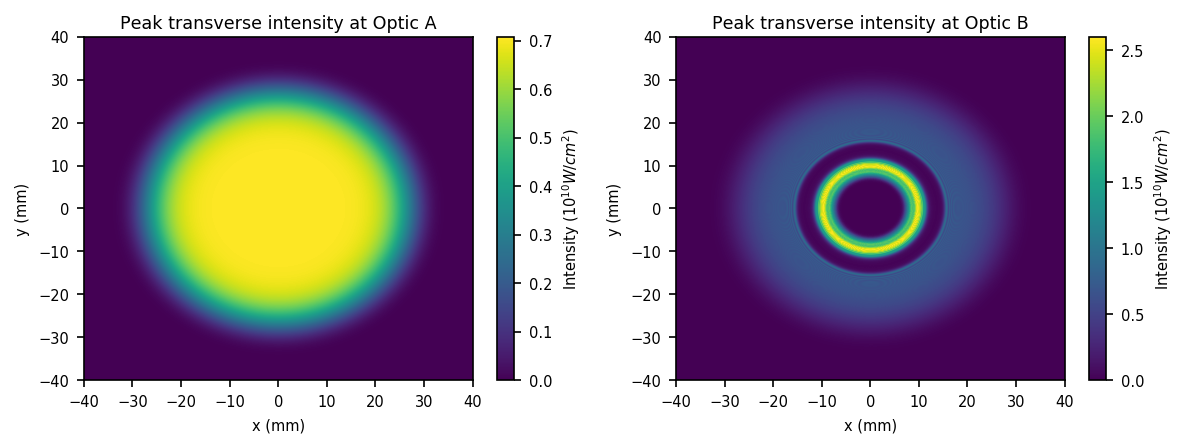

In [5]:
n = 8
w0 = 30e3
r0 = np.linspace(0, 100e3, 5000)
E0 = np.exp(-(r0/w0)**n)*multi
beam0 = design.propagate_to_lens_B(r0, E0, L, path, lam, lensA, tau)

Maximum phase change in one pixel 0.24 rad/um


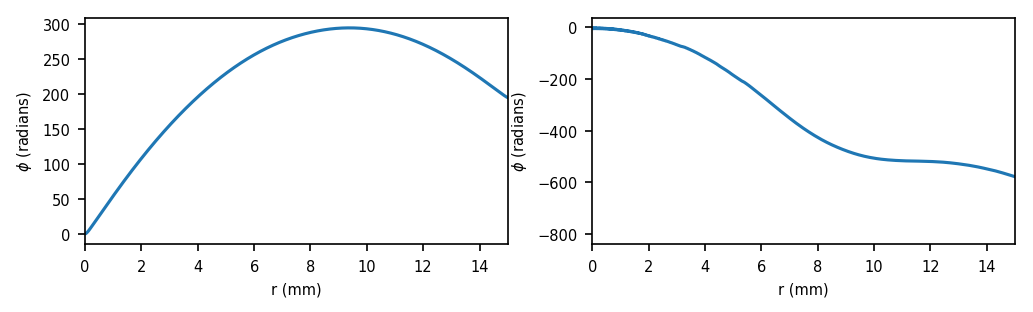

In [6]:
Nx = 2**12
X = 40e3
rB, phiB, lensB = design.create_lens_B(beam0, r, E, path, lam, X, Nx)
design.plot_phase(rA, phiA, rB, phiB, [0, 15])

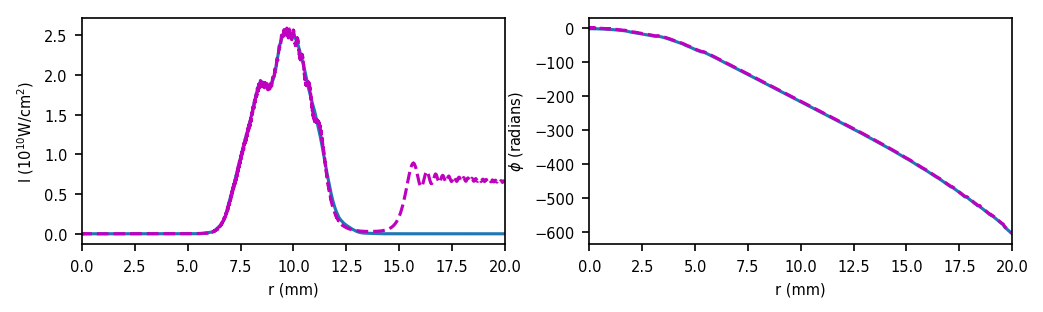

In [7]:
r1, e1 = design.field_after_lens_B(beam0, rB, phiB, r, E, [0, 20])
del beam0

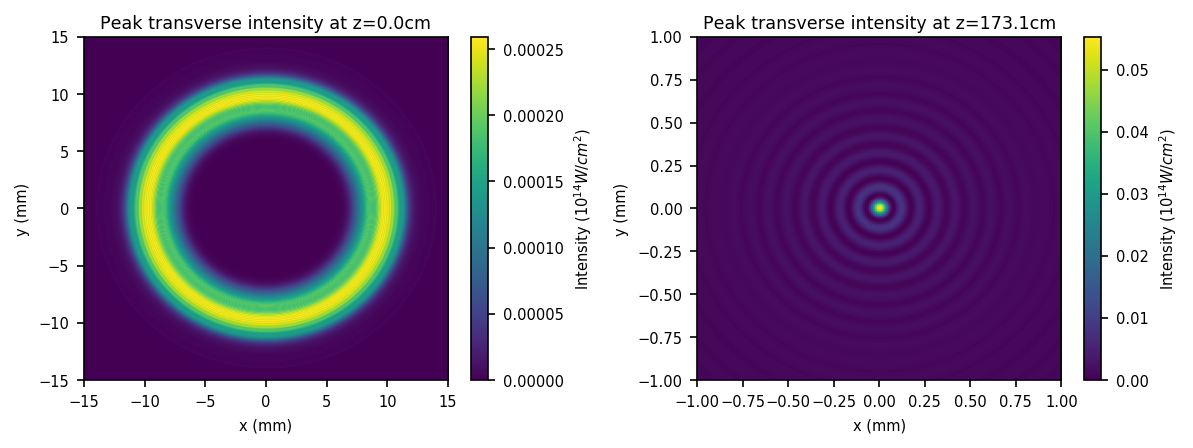

In [8]:
sel = r1 > 14e3 # Stop the outer rings from propagating
e1[sel] = 0.0
X = 30e3
Nx = 2**13
beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-10e4, X, Nx, path, lam, tau, 20, [-1, 1])

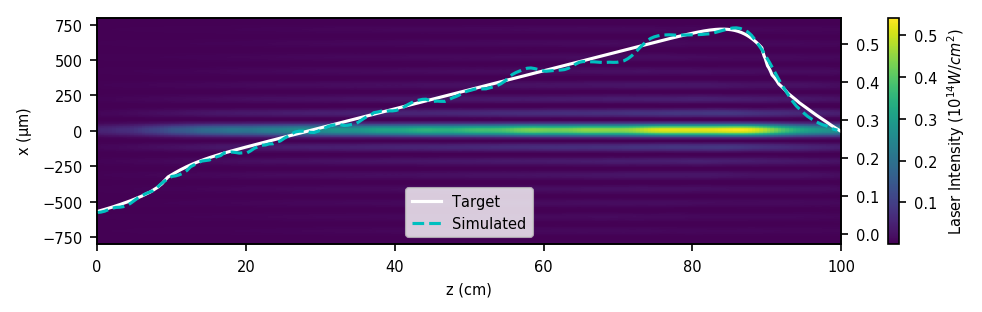

In [9]:
Nx = 2**11
Nz = 200
X = 10e3
Z = 100e4
design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, z0-10e4, [-800, 800])
del beam_start

Total input energy 4.58mJ


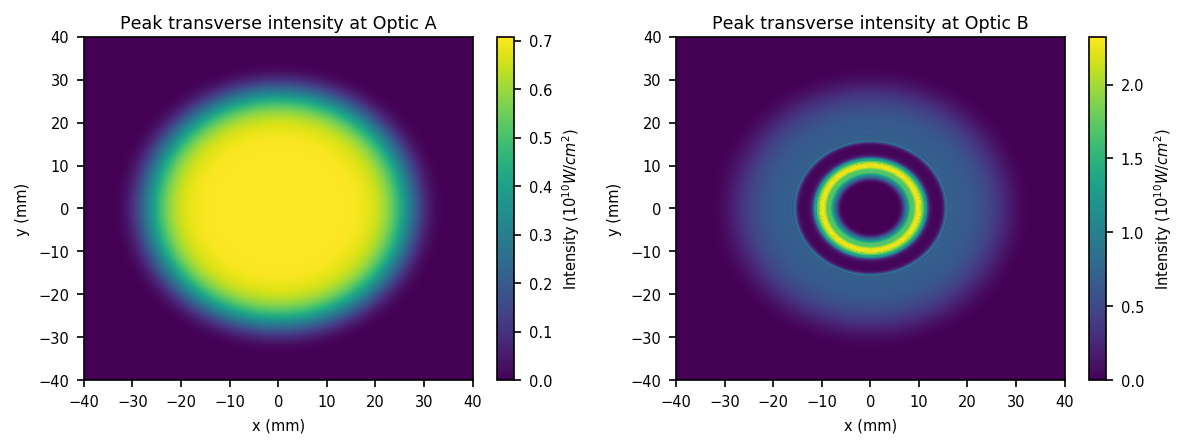

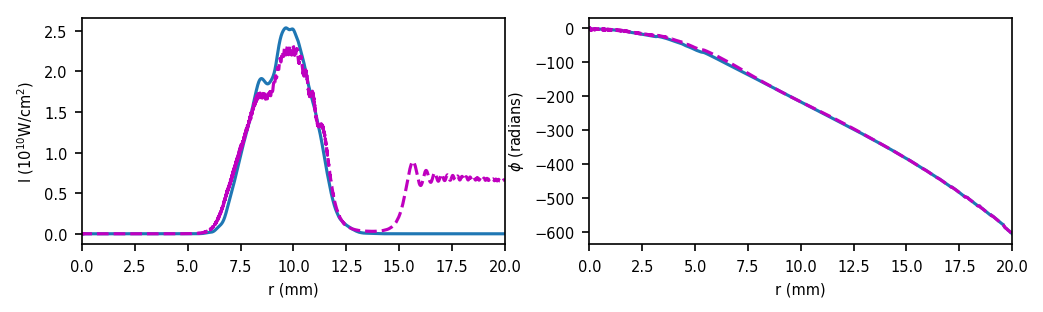

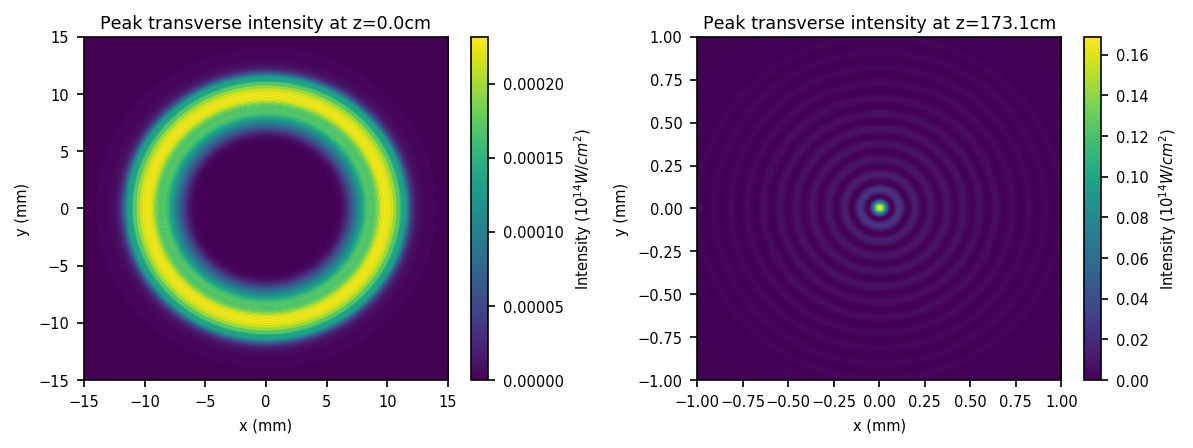

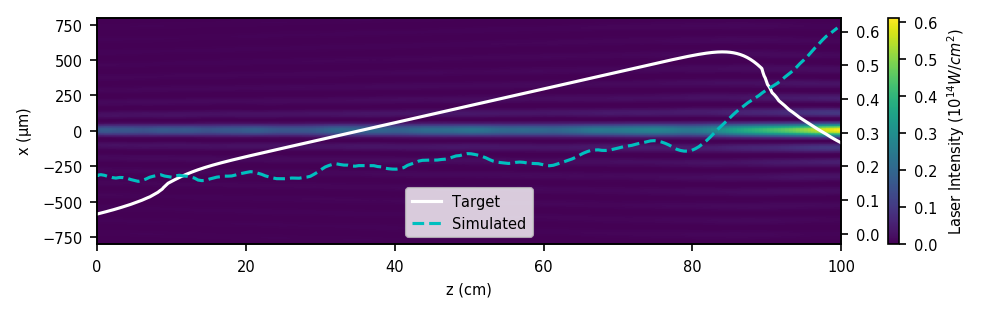

In [11]:
# Test spacing between lenses
beam_L = design.propagate_to_lens_B(r0, E0, L-40e3, path, lam, lensA, tau)
r1, e1 = design.field_after_lens_B(beam_L, rB, phiB, r, E, [0, 20])
sel = r1 > 14e3 # Stop the outer rings from propagating
e1[sel] = 0.0
X = 30e3
Nx = 2**13
beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-10e4, X, Nx, path, lam, tau, 20, [-1, 1])
Nx = 2**11
Nz = 200
X = 10e3
Z = 100e4
design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, z0-10e4, [-800, 800])
del beam_start
del beam_L